##### Tutorial on making the plot Interactive #####
https://saturncloud.io/blog/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook/#:~:text=To%20make%20our%203D%20plot,using%20our%20mouse%20or%20trackpad. 

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib inline
# I didn't have the line "%matplotlib inline" and then the plots weren't showing 

# What's really important is %matplotlib widget cause that's how I was able to make it interactive

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np

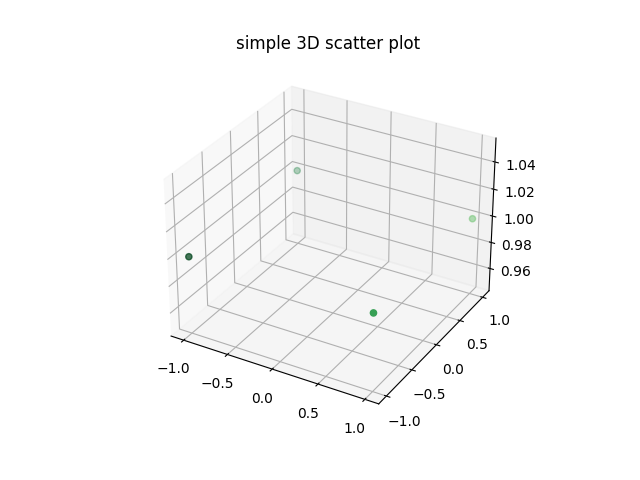

In [4]:
# Creating dataset
square = np.array([[1, 1, 1], [1, -1, 1], [-1, 1, 1], [-1, -1, 1]])

# Creating figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
 
# Create a gradient for the colorsx
num_points = square.shape[0]
gradient = np.linspace(0.5, 1, num_points)
colors = plt.cm.Greens(gradient)

# Creating plot
ax.scatter(square[:, 0], square[:, 1], square[:, 2], c=colors)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

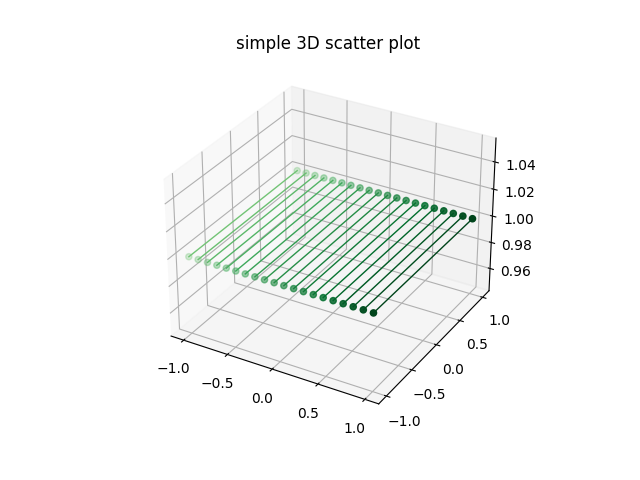

In [7]:
# Create green dots for left side of line
num_dots = 20

left_green = np.linspace(-1, 1, num_dots).reshape((-1, 1)) # x values
left_neg_ones = -1*np.ones((left_green.shape))
left_ones =  np.ones(left_green.shape)
left_green_points = np.concatenate((left_green, left_neg_ones, left_ones), axis=1)


right_green = np.linspace(-1, 1, num_dots).reshape((-1, 1))
right_neg_ones = np.ones((right_green.shape))
right_ones =  np.ones(right_green.shape)
right_green_points = np.concatenate((right_green, right_neg_ones, right_ones), axis=1)

# Creating figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

gradient = np.linspace(0.5, 1, num_dots)
colors = plt.cm.Greens(gradient)

# Creating plot
ax.scatter(left_green_points[:, 0], left_green_points[:, 1], left_green_points[:, 2], c=colors)
ax.scatter(right_green_points[:, 0], right_green_points[:, 1], right_green_points[:, 2], c=colors)
for i in range(left_green.shape[0]):
    ax.plot([left_green_points[i, 0], right_green_points[i, 0]], [left_green_points[i, 1], right_green_points[i, 1]], [left_green_points[i, 2], right_green_points[i, 2]], c=colors[i], linewidth=1)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

# TODO: Draw a line between all of these points using a for loop

# print(left_green_points)



#### Homography Explained With Code ####
https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html 

#### Youtube Video Explaining Homography ####

- 2x2 Image Transformations: https://youtu.be/K2XLXlyPqCA 

- 3x3 Image Transformations: https://www.youtube.com/watch?v=B8kMB6Hv2eI

- Homography: https://www.youtube.com/watch?v=l_qjO4cM74o 